In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from combo import combo
%pylab inline
from datetime import datetime, timedelta, date
import time
import scipy.stats as stat
from scipy import optimize
import statsmodels.formula.api as smf
from geopy.distance import vincenty

RootPath = '/Users/CQ/Documents/Project1'

Populating the interactive namespace from numpy and matplotlib


In [2]:
twitter_file = pd.read_csv(RootPath + '/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv(RootPath + '/USzipcode_XY.csv')
twitter_file.columns = ['Date','Time','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']
twitter_file.Time = pd.to_datetime(twitter_file.Time, unit='s') - timedelta(hours=5) ## UTS - 5h NYC
twitter_file.Date = twitter_file.Time.dt.date

PLACES = twitter_file.ZipCode.unique()

In [3]:
start_date = twitter_file.iloc[0,0]
end_date = twitter_file.iloc[-1,0]
day_count = (end_date-start_date).days + 1
DateList = [start_date + timedelta(n) for n in range(day_count)]

In [4]:
def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

In [5]:
Days = range(day_count)
for single_day in DateList:
    Days[DateList.index(single_day)] = twitter_file[twitter_file.Date == single_day]
    Days[DateList.index(single_day)] = Clean_zipcode(Days[DateList.index(single_day)])

In [6]:
def NaiveNetBuild(dataset):
    """This function is for initializing our network with the form of
    (zip1), (zip2), (number of people who visited both places)
    """
    places = list(dataset.ZipCode.unique())
    #user = list(dataset.User.unique())
    lzip = len(places)
    count_total = range(lzip**2)
    for i in places:
        ix_i = places.index(i)
        a1 = set(dataset[dataset.ZipCode == i].User)  #ID of people who visited place i
        b1 = sum(dataset.ZipCode == i)                #number of tweets captured at place i
        c1 = len(a1)                                  #number of people who visited place i
        for j in places:
            ix_j = places.index(j)
            a2 = set(dataset[dataset.ZipCode == j].User)  #ID of people who visited place j
            b2 = sum(dataset.ZipCode == j)                #number of tweets captured at place j
            c2 = len(a2)                                  #number of people who visited place j
            count_total[ix_i * lzip + ix_j] = (i,j, len(a1 & a2), b1, b2, c1, c2)

    return pd.DataFrame(count_total, columns = ['zip1','zip2','weight','tweet1','tweet2','people1','people2'])

def ProbNetBuild(dataset):
    user = sort(dataset.User.unique())
    places = list(sort(dataset.ZipCode.unique()))
    lzip = len(places)
    if dataset.empty:
        return pd.DataFrame(columns = ['zip1','zip2','weight','tweet1','tweet2','people1','people2'])
    else:
        grouped = dataset['ZipCode'].groupby(dataset['User'])
        a = grouped.value_counts()
        b = a.unstack(level = -1).fillna(0)
        data = pd.DataFrame(b, columns = places, index = user)
        T = data.sum().sum()*1.0
        tc = data.sum(axis = 1)
        #TC = dict(zip(list(dataset.UserID), tc))
        ix_tc = tc > 1
        count_total = range(lzip**2)
        #the formula is provided before
        for i in places:
            ix_i = places.index(i)
            a1 = set(dataset[dataset.ZipCode == i].User)  #ID of people who visited place i
            b1 = sum(dataset.ZipCode == i)                #number of tweets captured at place i
            c1 = len(a1)                                  #number of people who visited place i
            for j in places:
                ix_j = places.index(j)
                if ix_j < ix_i:
                    continue
                else:
                    a2 = set(dataset[dataset.ZipCode == j].User)  #ID of people who visited place j
                    b2 = sum(dataset.ZipCode == j)                #number of tweets captured at place j
                    c2 = len(a2)                                  #number of people who visited place j
                    delta = 0 if ix_i < ix_j else 1
                    w = data.loc[:,i][ix_tc] * data.loc[:,j][ix_tc] / (tc[ix_tc]-1)
                    count_total[ix_j * lzip + ix_i] = (j,i, sum(w)/T, b2, b1, c2, c1)
                    count_total[ix_i * lzip + ix_j] = (i,j, sum(w)/T, b1, b2, c1, c2)
    return pd.DataFrame(count_total, columns = ['zip1','zip2','weight','tweet1','tweet2','people1','people2'])

In [7]:
def Dist_Centr_Comp1(date_index, net_index, centrality, city_ziplist = PLACES, ziplist = USzipcode):
    '''
    First method, we extract zip codes' coordinates by simply using data from USzipcode.csv
    Centrality's options are
    1--degree centrality, the number of tweets captured at each zip code
    2--page rank centrality, calculated previously
    '''
    network = pd.DataFrame(Net1Day[date_index],copy = True) if net_index == 1 else pd.DataFrame(Net2Day[date_index],
                                                                                                copy = True)
    leng = len(network)
    ziplist = ziplist[ziplist.ZipCode.isin(city_ziplist)]
    zipdict = {int(ziplist.iloc[i,0]):(ziplist.iloc[i,1],ziplist.iloc[i,2]) for i in range(len(ziplist))}
    temp = network.loc[:,['zip1','zip2']]
    distance = [vincenty(zipdict[network.zip1[i]], zipdict[network.zip2[i]]).miles for i in range(leng)]
    network['distance'] = distance
    return network

In [43]:
Net1Day, Net2Day = range(day_count), range(day_count)
for i in range(day_count):
    Net1Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Naive/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)
    Net2Day[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Prob/Original/Day %d of Twitter Data.csv'%(i+1), index_col=0)

In [44]:
Net1GravDegree, Net2GravDegree = range(day_count), range(day_count)
for i in range(day_count):
    Net1GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Naive/DegCentrality/Day %d.csv'%(i+1), index_col=0)
    Net2GravDegree[i] = pd.read_csv(RootPath+'/GravModel/TimeSeries/Prob/DegCentrality/Day %d.csv'%(i+1), index_col=0)

In [51]:
def LMOutput(model_index = 1, net_index = 1, centrality_index = 1):
    LM = range(day_count)
    for i in range(day_count):
        if centrality_index == 1:
            data = Net1GravDegree[i].iloc[:,2:] if net_index == 1 else Net2GravDegree[i].iloc[:,2:]
        else:
            data = Net1GravPageRk[i].iloc[:,2:] if net_index == 1 else Net2GravPageRk[i].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        if sum(missing_check) == 0:
            LM[i] = False
        else:
            if model_index == 1:
                LM[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = data).fit()
            else:
                random.seed(2016)
                ind=stat.bernoulli.rvs(p = 0.67, size = len(data.weight))
                train=data.loc[ind==1]
                valid=data.loc[ind==0]
                LM[i] = smf.ols(formula='log(weight) ~ log(distance)+log(tweet1)+log(tweet2)', data = train).fit()
    index = [LM.index(x) for x in LM if x]
    datelist = [DateList[i] for i in index]
    size = len(index)
    nrows = size/6 + (size%6!=0)
    ncols = 6    
    Title = 'Naive Network' if net_index ==1 else 'Probabilistic Network'
    plt.figure(figsize=(20, 4.8*nrows))
    plt.suptitle(Title, fontweight="bold", size = 18)
    summary = []
    for i in range(size):
        plt.subplot(nrows, ncols, i+1)
        lm = LM[index[i]]
        if centrality_index == 1:
            data = Net1GravDegree[index[i]].iloc[:,2:] if net_index == 1 else Net2GravDegree[index[i]].iloc[:,2:]
        else:
            data = Net1GravPageRk[index[i]].iloc[:,2:] if net_index == 1 else Net2GravPageRk[index[i]].iloc[:,2:]
        missing_check = (data.distance > 0) & (data.weight > 0)
        data = data.loc[missing_check]
        if model_index == 1:
            lme = lm.predict(data)
            plt.plot(lme,log(data.weight),'or')
            plt.plot(lme,lme,'-b')
            plt.title(datelist[i], fontweight='bold')
            summary.append([lm.rsquared, lm.pvalues[0],lm.pvalues[1],lm.pvalues[2],lm.pvalues[3],
                    lm.params[0],lm.params[1],lm.params[2],lm.params[3]])
        else:
            lme = lm.predict(valid)
            plt.plot(lme,log(valid.weight),'or')
            plt.plot(lme,lme,'-b')
            R2=1-sum(pow(log(valid.weight)-lme,2))/sum(pow(log(valid.weight)-mean(log(valid.weight)),2))
            plt.title(datelist[i].strftime("%Y-%m-%d")+'\nValidation error=%f'%R2, fontweight='bold')
            summary.append([lm.rsquared, lm.pvalues[0],lm.pvalues[1],lm.pvalues[2],lm.pvalues[3],
                    lm.params[0],lm.params[1],lm.params[2],lm.params[3]])
    return pd.DataFrame(summary,columns = ['R^2','Intercept_p_value','Dist_p_value','Tweet1_p_value',
         'Tweet2_p_value','Intercept','Dist','Tweet1','Tweet2'], index = datelist)

,R^2,Intercept_p_value,Dist_p_value,Tweet1_p_value,Tweet2_p_value,Intercept,Dist,Tweet1,Tweet2
2015-11-04,0.040018,9.294857e-01,2.004538e-01,2.345683e-01,2.345683e-01,-0.003048,-0.012221,0.008791,0.008791
2015-11-05,0.253614,2.669622e-122,1.245806e-06,0.000000e+00,0.000000e+00,-0.510498,-0.025585,0.148862,0.148862
2015-11-06,0.274718,1.131336e-63,1.455422e-95,0.000000e+00,0.000000e+00,-0.403990,-0.116828,0.142949,0.142949
2015-11-07,0.283253,3.509289e-69,1.350810e-56,1.073198e-272,1.073198e-272,-0.588851,-0.116289,0.160093,0.160093
2015-11-08,0.346872,2.806347e-92,2.437978e-146,1.377105e-308,1.377105e-308,-0.660742,-0.194954,0.166527,0.166527
2015-11-09,0.200301,3.886252e-36,4.124445e-02,1.986090e-293,1.986090e-293,-0.307679,-0.011863,0.125744,0.125744
2015-11-10,0.283541,1.032032e-80,2.077321e-48,0.000000e+00,0.000000e+00,-0.441538,-0.082624,0.147788,0.147788
2015-11-11,0.234062,5.539041e-25,8.328852e-33,2.864107e-92,2.864107e-92,-0.344229,-0.099631,0.101119,0.101119
2015-11-16,0.220141,9.742451e-23,7.276109e-61,5.465591e-137,5.465591e-137,-0.319803,-0.122040,0.117988,0.117988
2015-11-17,0.272410,2.109213e-69,1.554921e-98,0.000000e+00,0.000000e+00,-0.391077,-0.120280,0.127148,0.127148


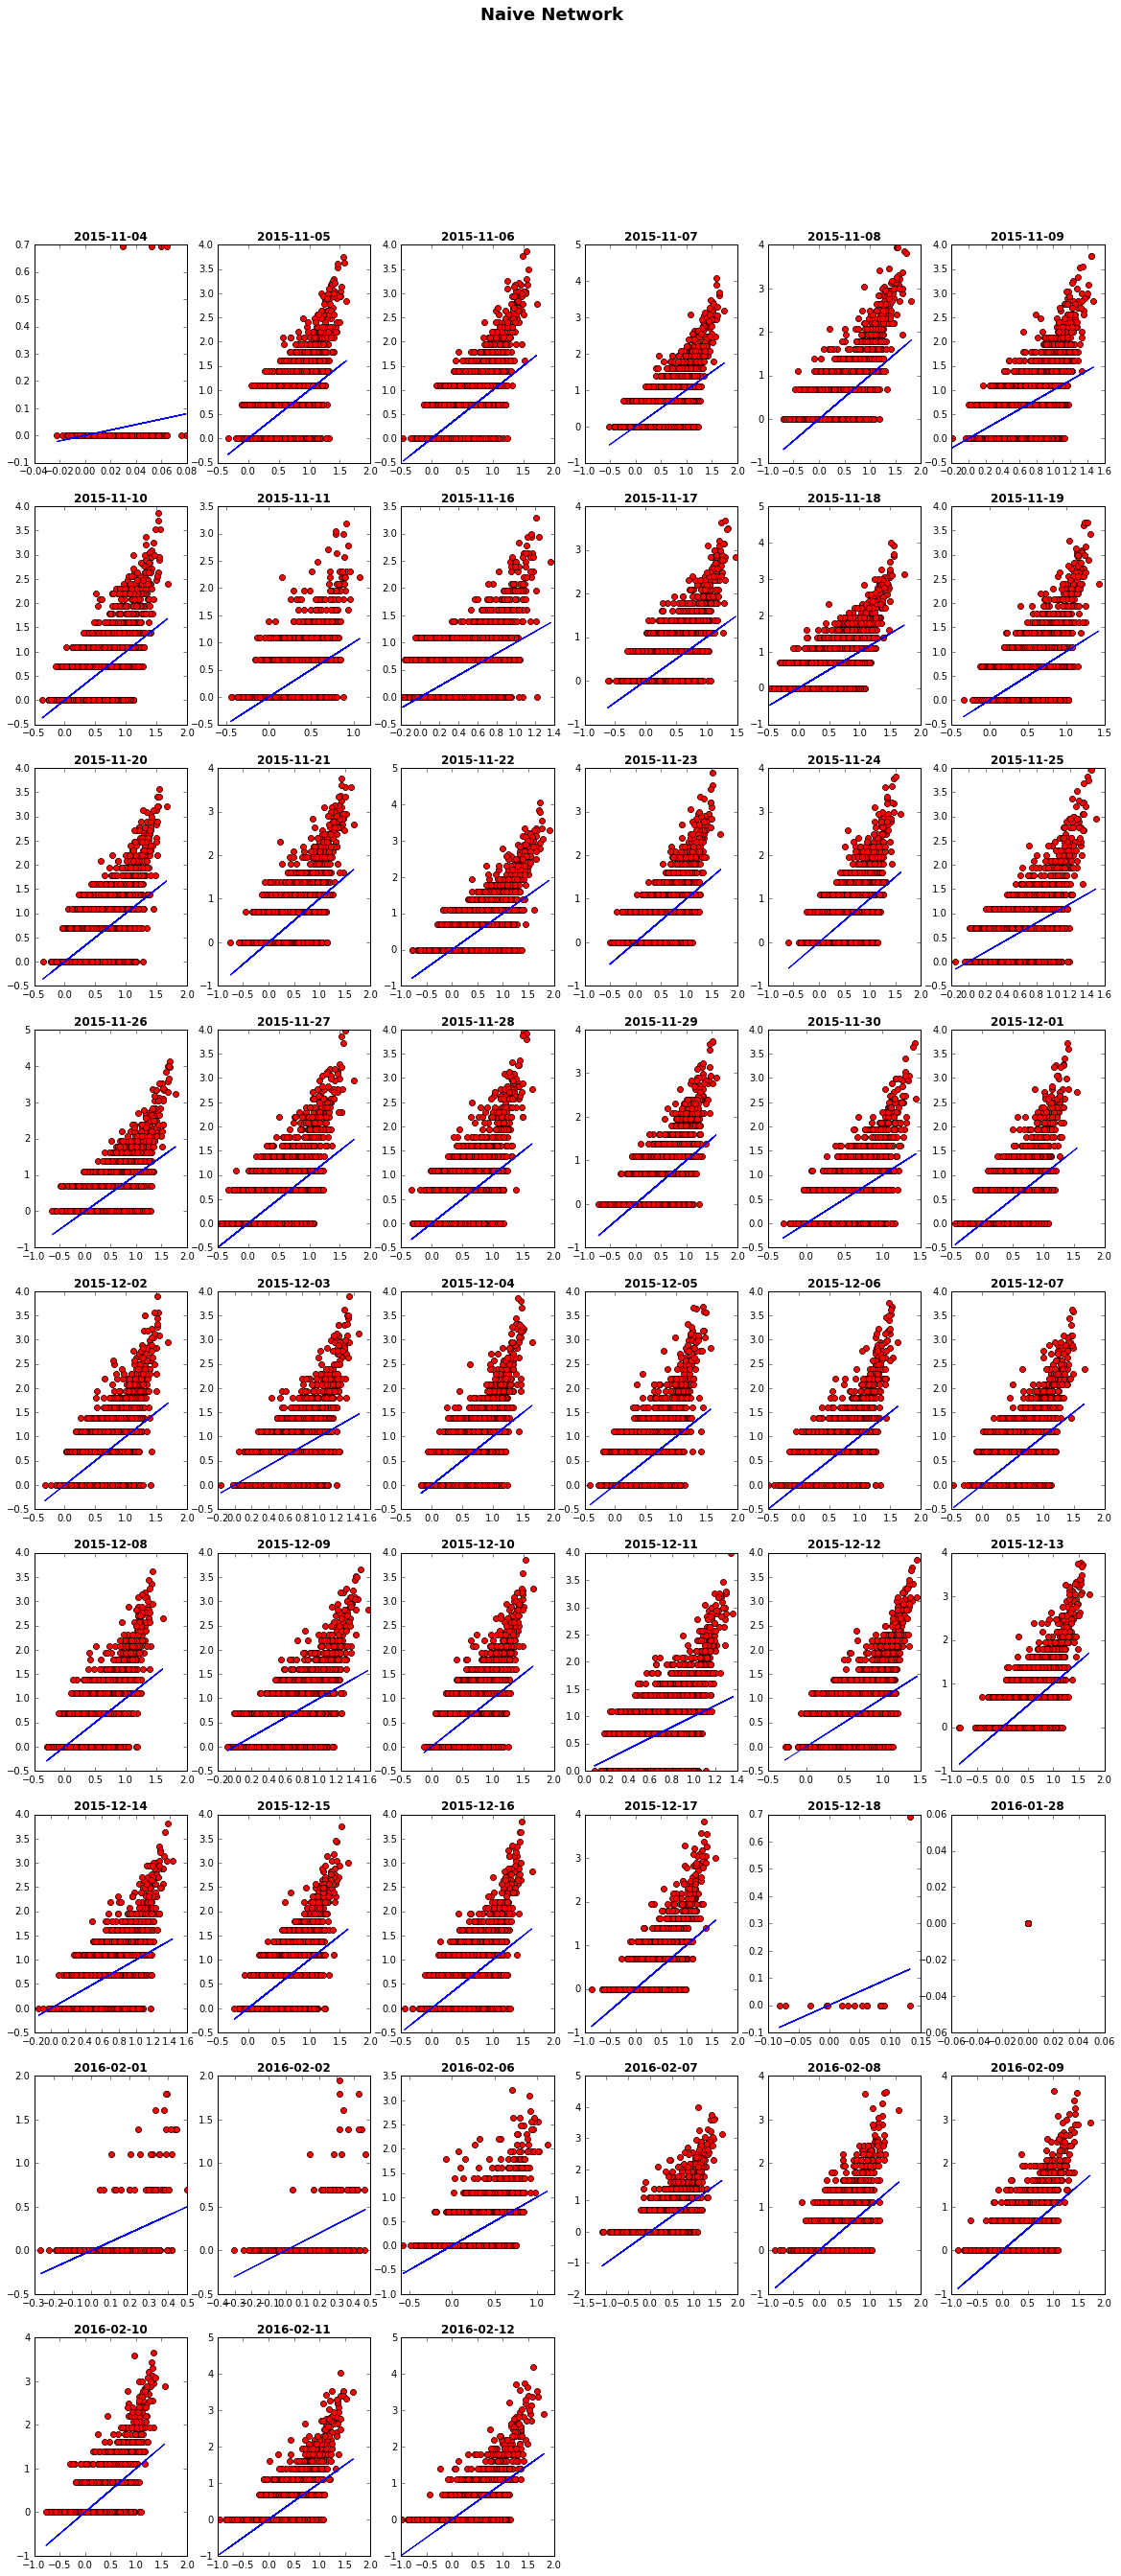

In [52]:
LMOutput(1,1,1)

,R^2,Intercept_p_value,Dist_p_value,Tweet1_p_value,Tweet2_p_value,Intercept,Dist,Tweet1,Tweet2
2015-11-04,0.045759,5.656406e-01,9.522504e-02,5.983181e-01,4.735527e-01,0.027254,-0.021622,0.005286,0.006876
2015-11-05,0.257761,9.314572e-85,6.591469e-05,0.000000e+00,0.000000e+00,-0.521031,-0.025875,0.150399,0.150141
2015-11-06,0.264194,9.401050e-37,6.367344e-67,1.955817e-264,5.986442e-274,-0.370208,-0.119087,0.137728,0.140761
2015-11-07,0.274720,4.595532e-44,6.996176e-36,2.675265e-171,1.382250e-181,-0.582003,-0.114310,0.156885,0.160409
2015-11-08,0.350855,3.323325e-61,2.052222e-106,9.485472e-199,1.912836e-219,-0.637663,-0.198443,0.159549,0.169342
2015-11-09,0.190358,2.965053e-21,1.593981e-01,3.674839e-183,7.030766e-188,-0.286053,-0.010037,0.121400,0.123405
2015-11-10,0.288062,1.336957e-52,6.988467e-36,3.444318e-299,1.794532e-306,-0.433885,-0.087021,0.147398,0.149335
2015-11-11,0.244493,3.254197e-17,2.367922e-28,4.297240e-63,5.505716e-68,-0.335494,-0.110322,0.100377,0.103492
2015-11-16,0.209758,2.205356e-13,3.808132e-39,1.466313e-81,2.315466e-92,-0.295082,-0.119905,0.110071,0.118282
2015-11-17,0.280296,1.867006e-46,4.817070e-76,2.799784e-243,4.098867e-253,-0.390875,-0.127543,0.127219,0.130375


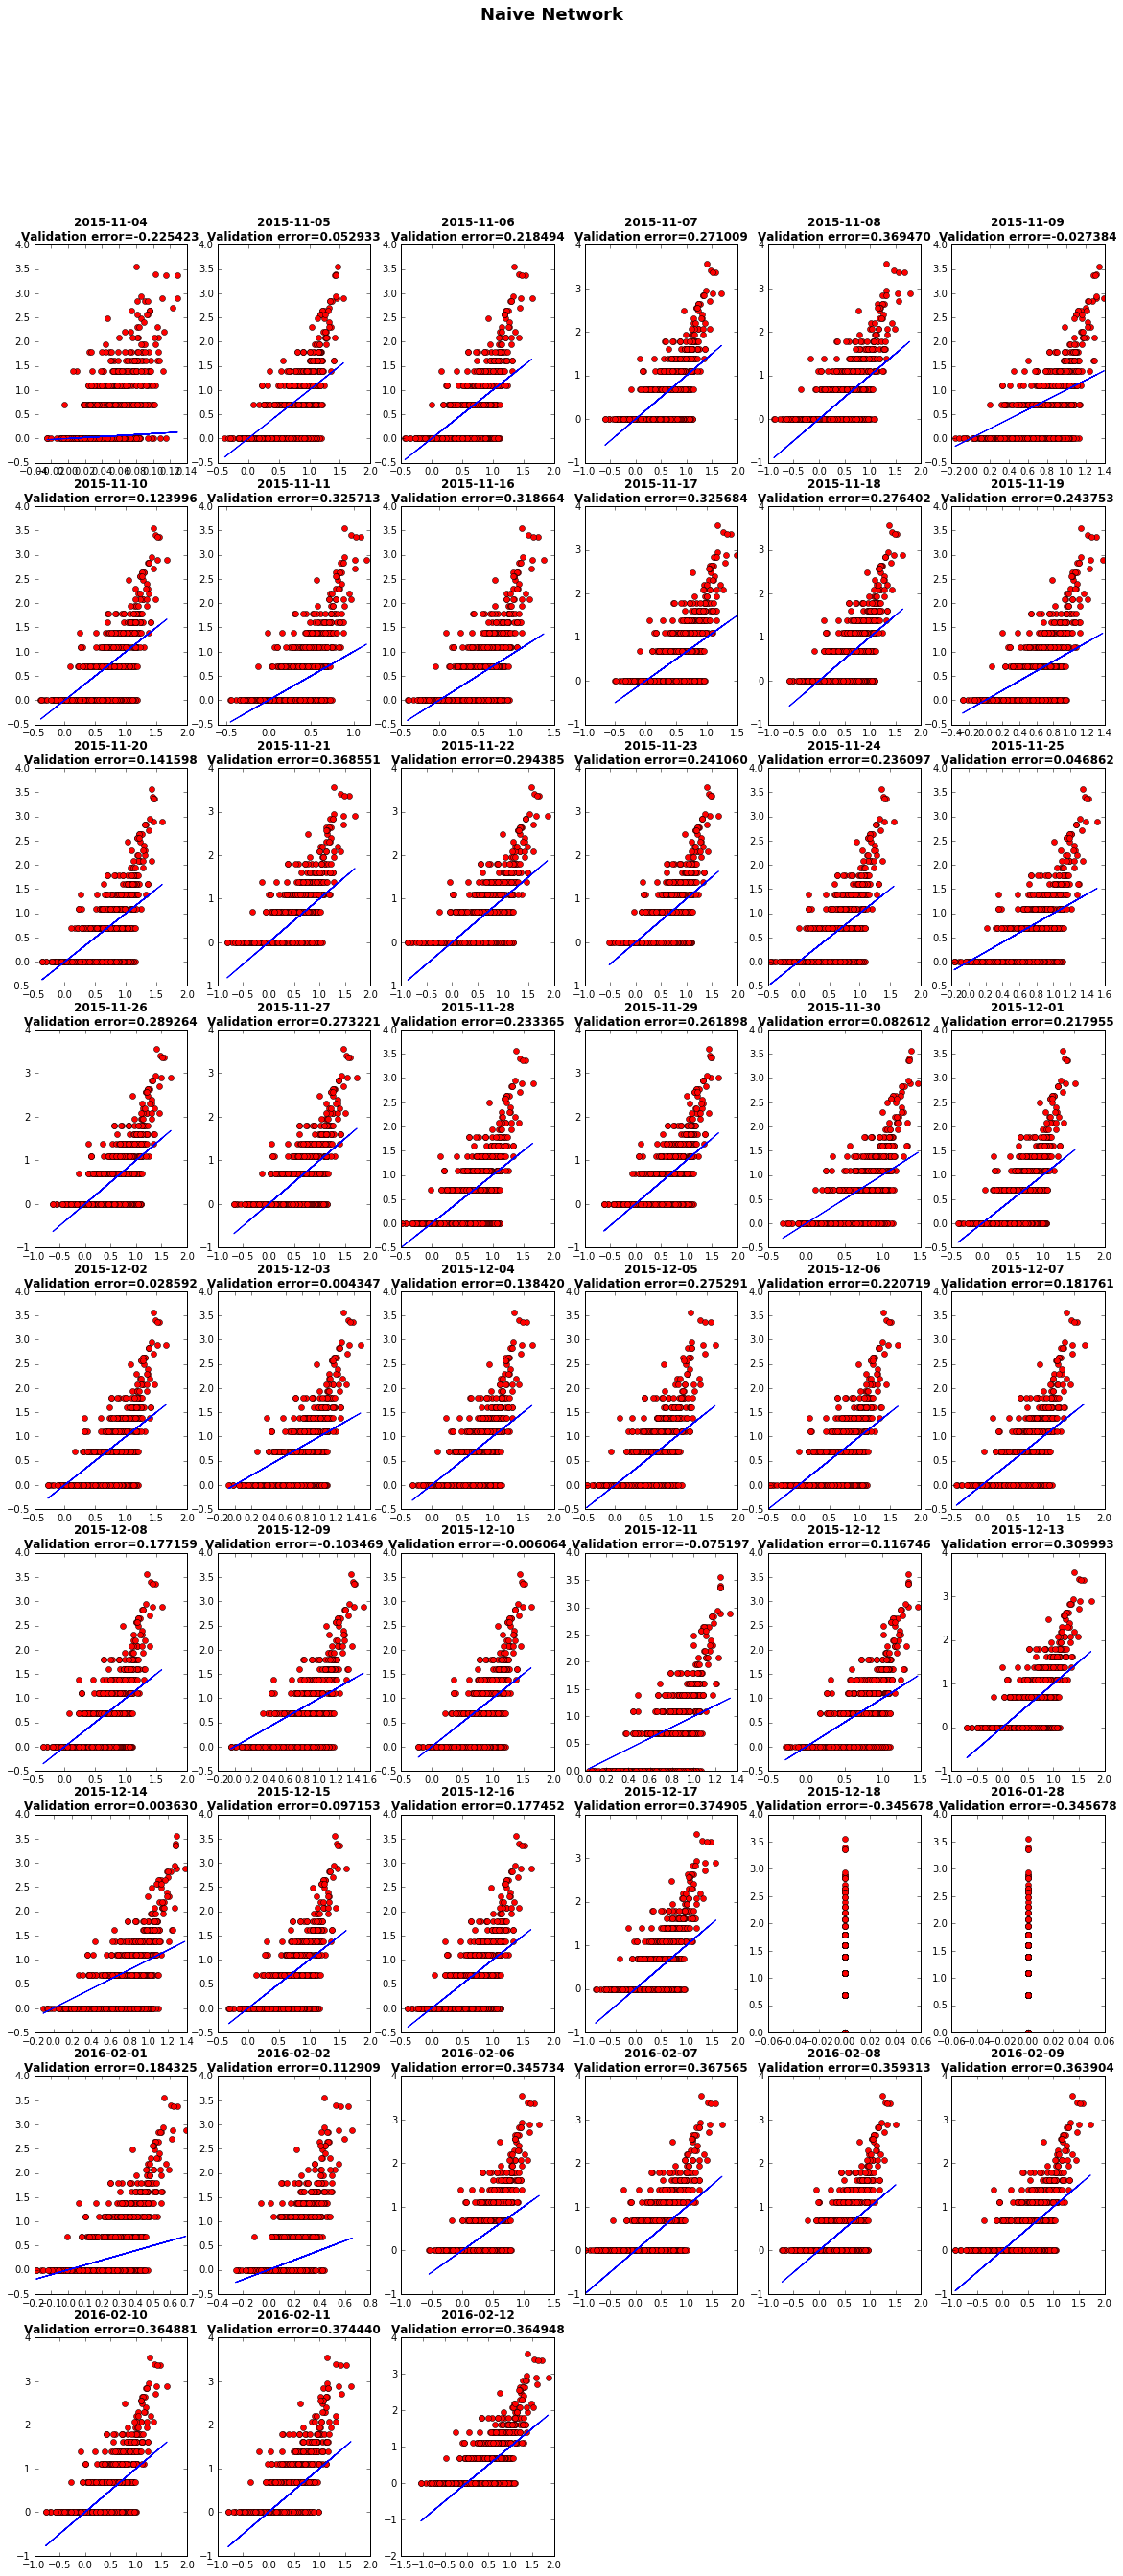

In [53]:
LMOutput(2,1,1)

,R^2,Intercept_p_value,Dist_p_value,Tweet1_p_value,Tweet2_p_value,Intercept,Dist,Tweet1,Tweet2
2015-11-04,0.103721,3.367427e-90,1.951867e-06,3.215301e-01,3.215301e-01,-7.423339,-0.292924,-0.046133,-0.046133
2015-11-05,0.353543,0.000000e+00,1.766104e-206,0.000000e+00,0.000000e+00,-15.442438,-0.490243,0.496713,0.496713
2015-11-06,0.342676,0.000000e+00,7.672753e-286,0.000000e+00,0.000000e+00,-14.750232,-0.624529,0.450585,0.450585
2015-11-07,0.336267,0.000000e+00,1.351714e-273,4.082826e-216,4.082826e-216,-13.581229,-0.714434,0.377057,0.377057
2015-11-08,0.312481,0.000000e+00,2.419817e-230,5.690212e-205,5.690212e-205,-13.944935,-0.744952,0.400160,0.400160
2015-11-09,0.357022,0.000000e+00,1.455688e-257,0.000000e+00,0.000000e+00,-14.321778,-0.590409,0.431506,0.431506
2015-11-10,0.326804,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-14.221071,-0.672806,0.407300,0.407300
2015-11-11,0.256890,0.000000e+00,1.348152e-100,2.243456e-65,2.243456e-65,-11.941709,-0.540325,0.250369,0.250369
2015-11-16,0.361261,0.000000e+00,7.846927e-229,1.096386e-193,1.096386e-193,-13.872491,-0.762723,0.439450,0.439450
2015-11-17,0.328983,0.000000e+00,7.311994e-265,0.000000e+00,0.000000e+00,-14.383262,-0.648619,0.416947,0.416947


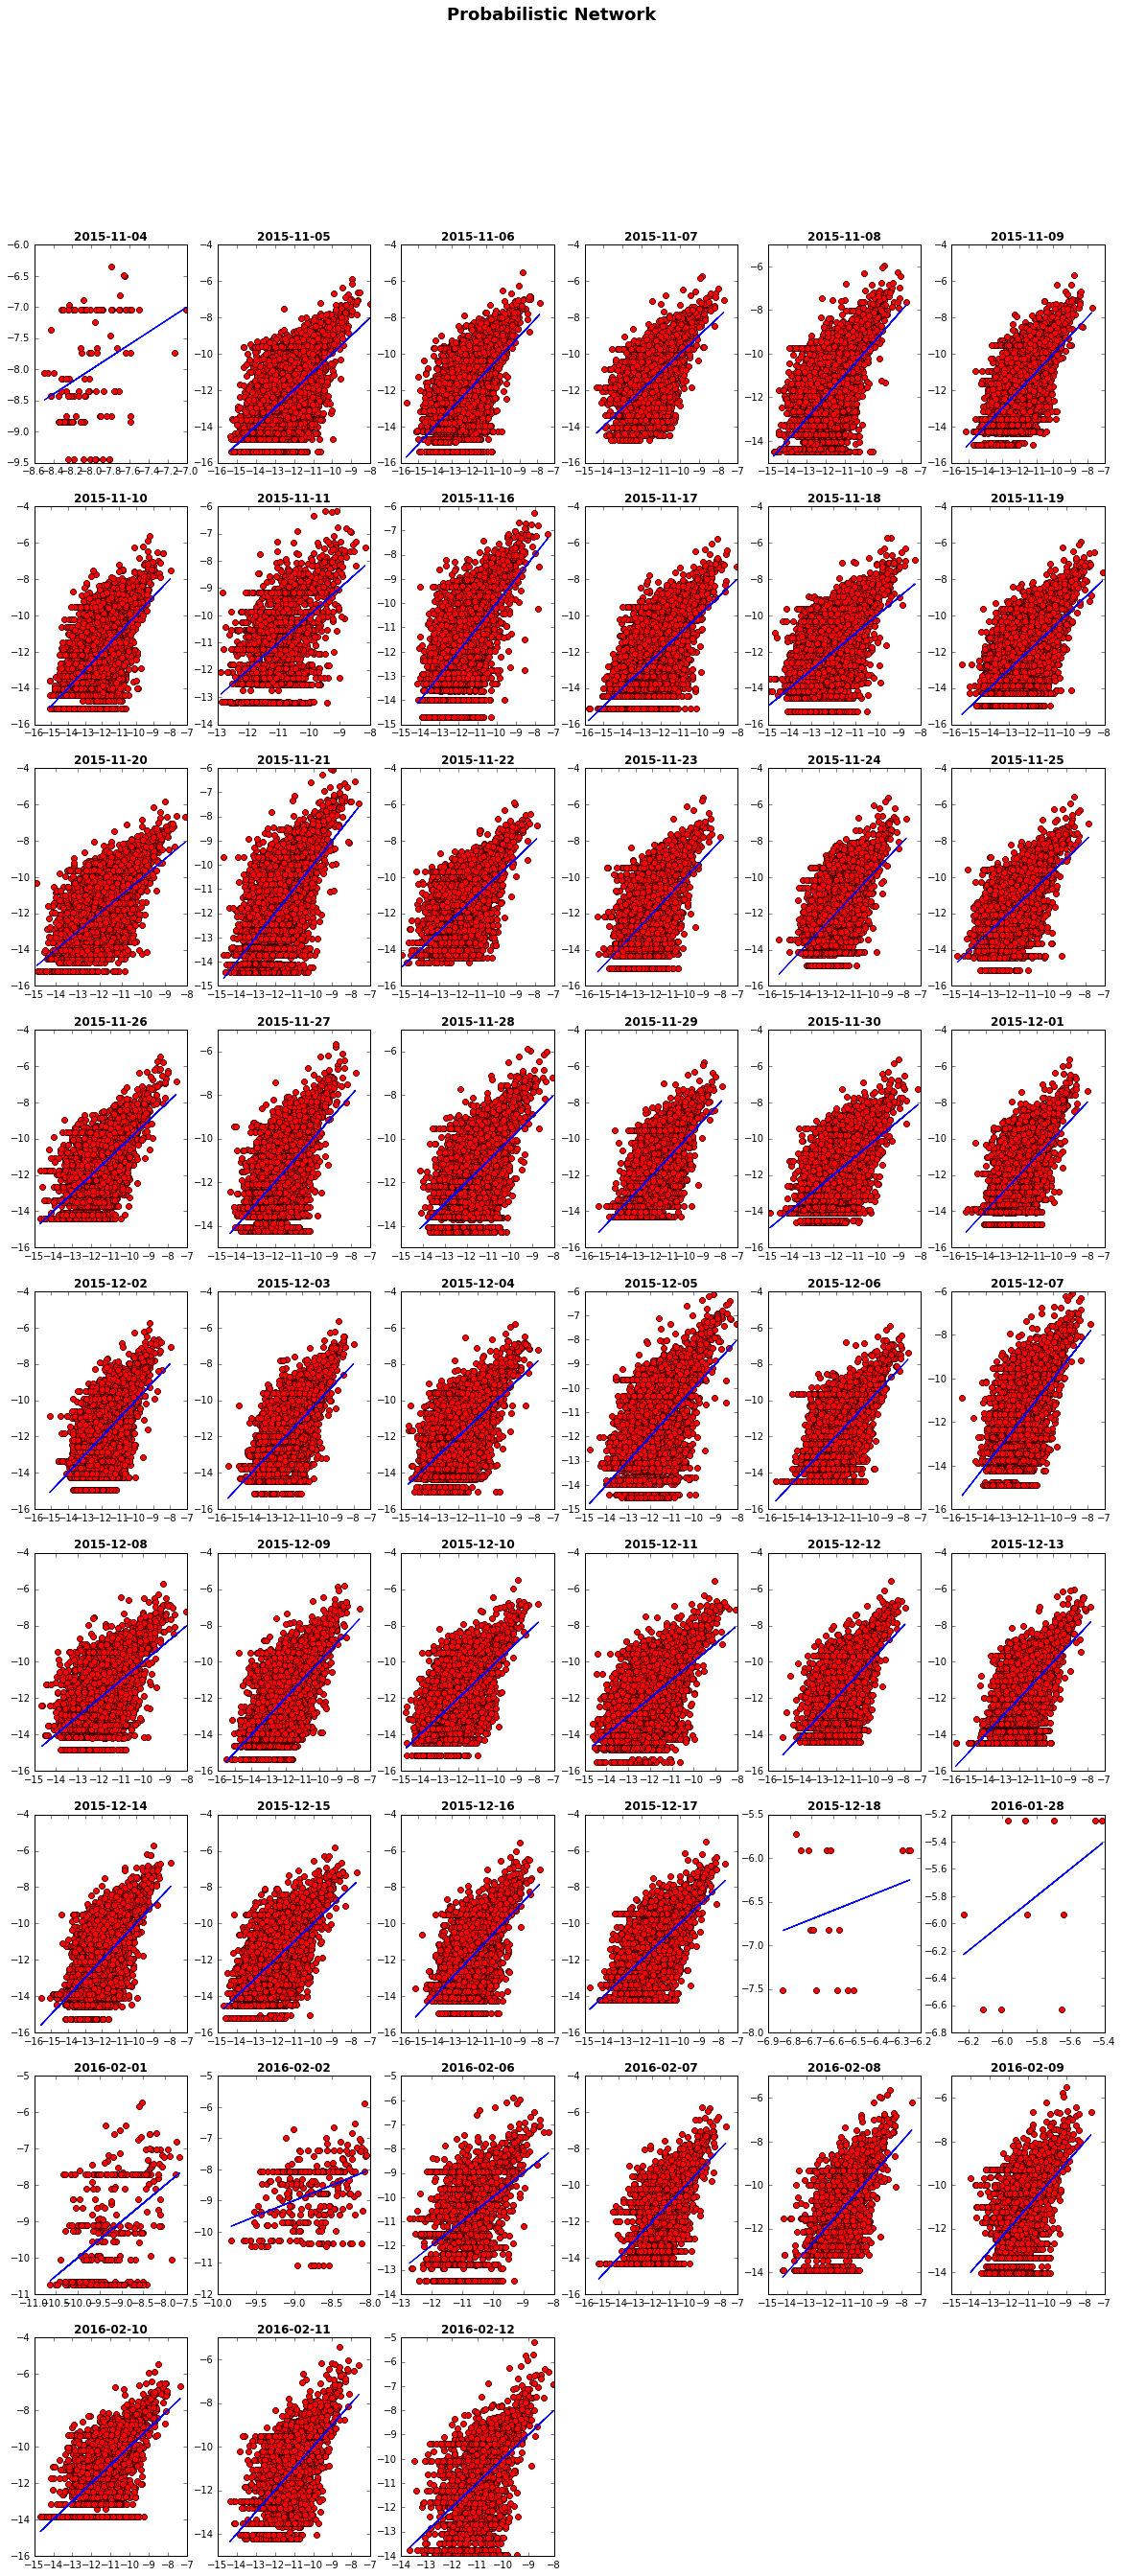

In [54]:
LMOutput(1,2,1)

,R^2,Intercept_p_value,Dist_p_value,Tweet1_p_value,Tweet2_p_value,Intercept,Dist,Tweet1,Tweet2
2015-11-04,0.105986,1.150536e-63,3.030616e-05,3.981756e-01,1.207547e-01,-7.312436,-0.315708,-0.046683,-0.089667
2015-11-05,0.359863,0.000000e+00,1.802727e-144,0.000000e+00,0.000000e+00,-15.457622,-0.495033,0.490373,0.508086
2015-11-06,0.343995,0.000000e+00,1.743062e-195,1.507617e-291,3.455815e-309,-14.697578,-0.633194,0.437313,0.451549
2015-11-07,0.331667,0.000000e+00,2.006341e-175,3.670955e-145,3.940843e-146,-13.615436,-0.702454,0.379995,0.378315
2015-11-08,0.308693,0.000000e+00,4.512079e-149,4.242671e-149,4.283097e-137,-14.045430,-0.724037,0.414812,0.398012
2015-11-09,0.353445,0.000000e+00,9.371401e-177,6.763578e-258,5.833213e-273,-14.276170,-0.601174,0.422000,0.431111
2015-11-10,0.331728,0.000000e+00,2.325219e-214,6.553499e-245,5.370809e-261,-14.238445,-0.679769,0.404252,0.417523
2015-11-11,0.258303,0.000000e+00,4.061424e-72,4.111634e-44,6.555203e-40,-11.854954,-0.554057,0.245428,0.237121
2015-11-16,0.367681,0.000000e+00,4.613372e-154,9.385884e-146,3.741357e-129,-13.976390,-0.751005,0.466637,0.434234
2015-11-17,0.332474,0.000000e+00,2.334699e-180,2.451381e-259,2.972693e-260,-14.386099,-0.655329,0.419777,0.419249


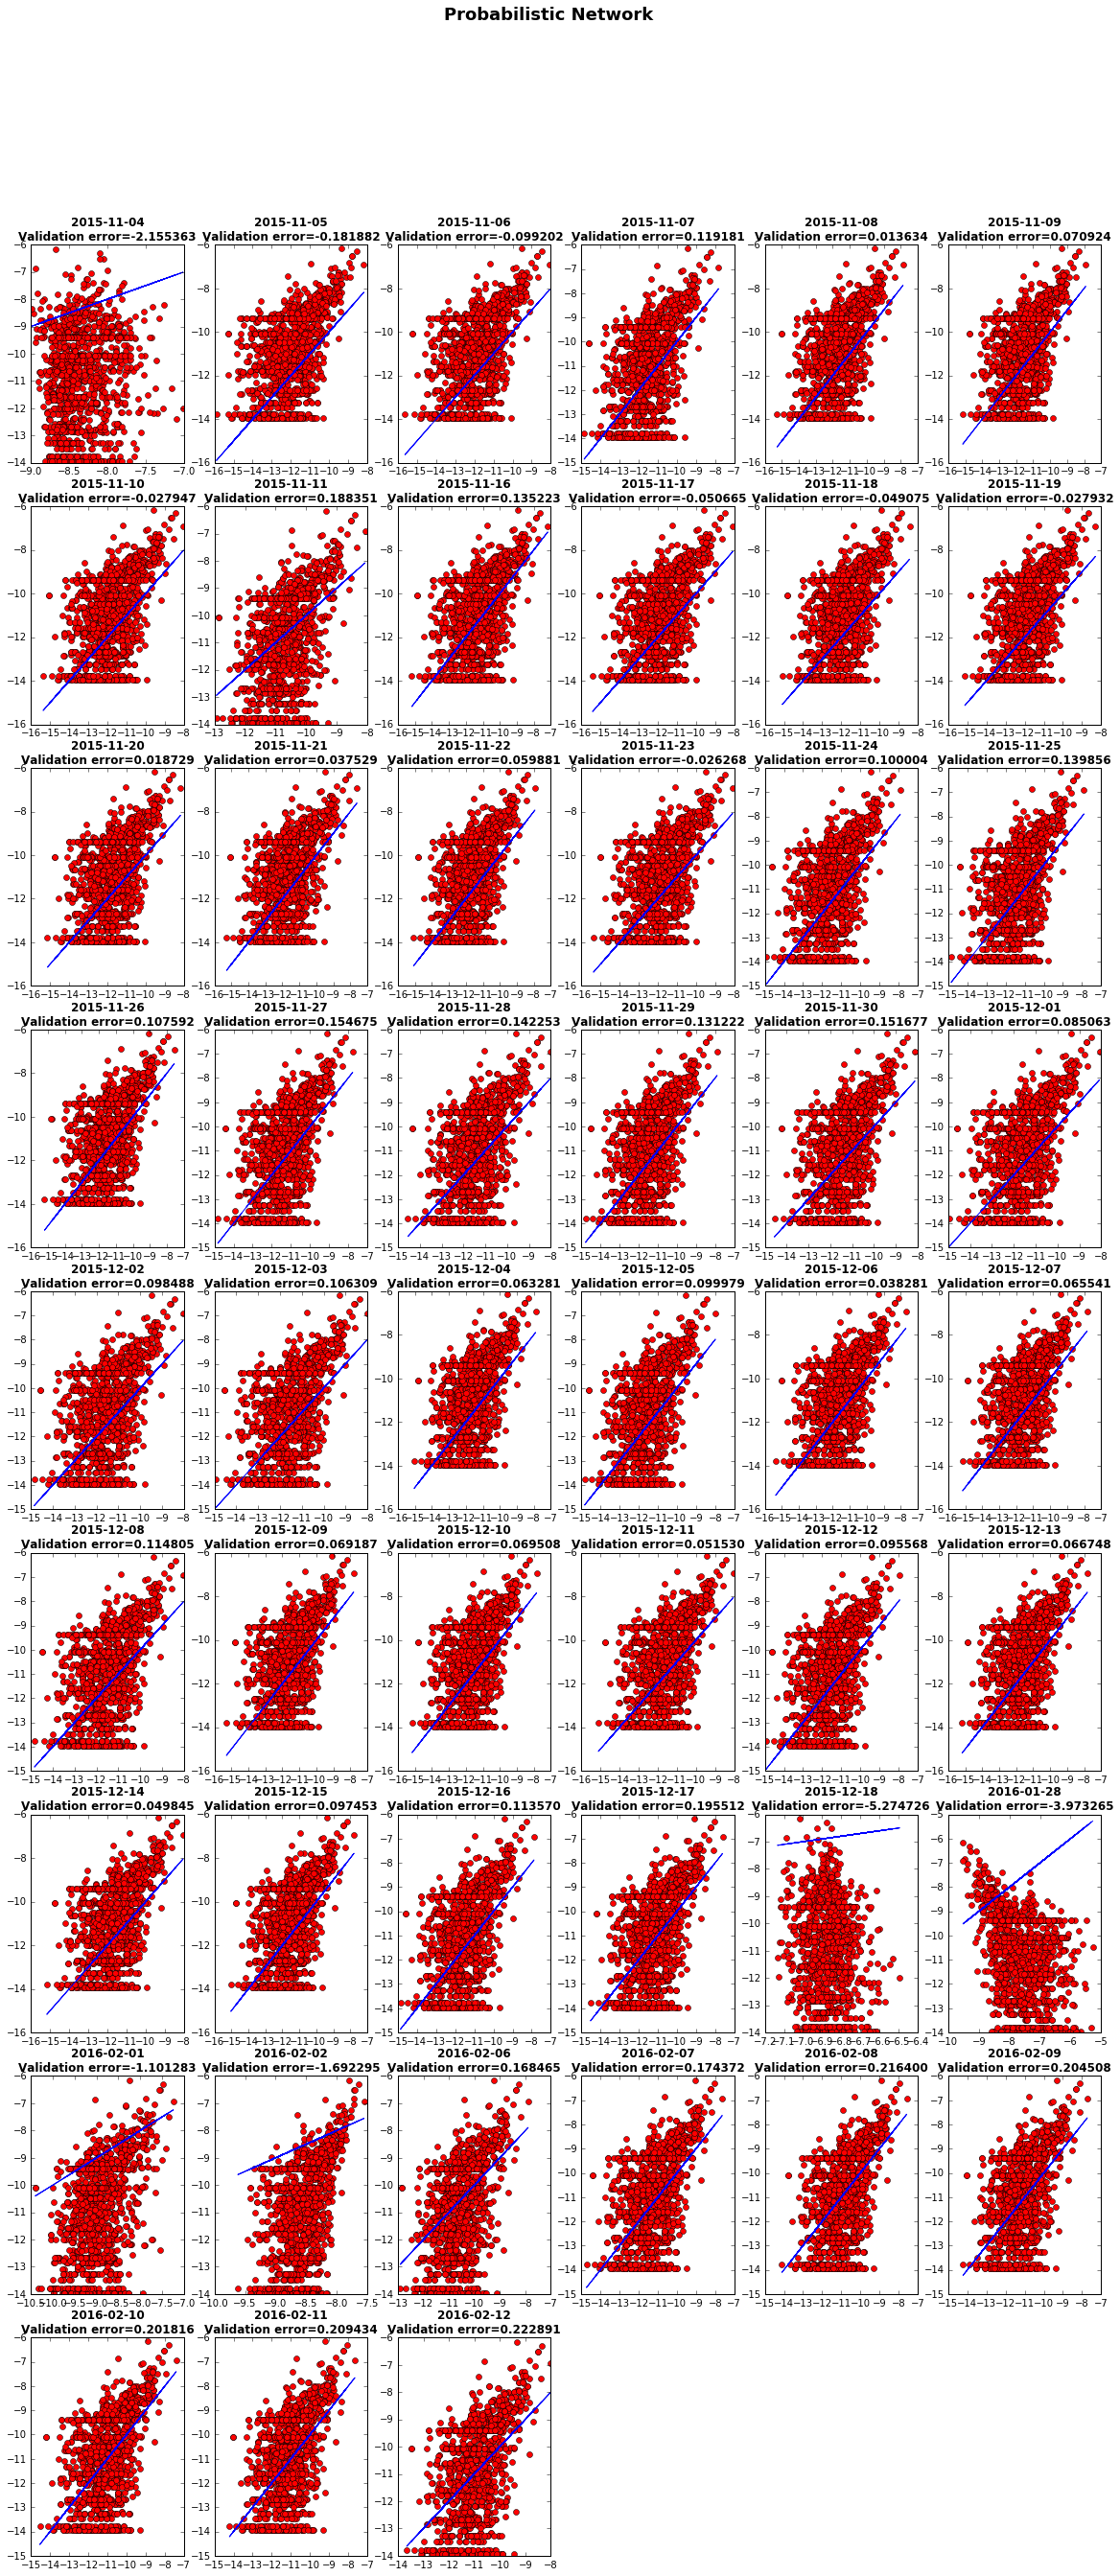

In [55]:
LMOutput(2,2,1)